In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string
import pandas as pd

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'14', 'fontname':'Times New Roman'}

del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [2]:

        
# main reads the data from csv file and plots it, it also saves the voltage profiles in a text file
def main(file_csv,tape_number,Vheater,filenumber,current_percent,filename,coating):
    # Uploading data from csv file
    data_ic_wo = pd.read_csv(file_csv)
    #time_ic_wo = data_ic_wo['time']
    
    # Creating time array from data using the sampling rate from CDAQ 0.19984 s
    last_index = len(data_ic_wo['v7_m']) 
    stop = (last_index)*(0.19984) 
    time_ic_wo = np.arange(0,stop,0.19984)
    
    # For loop to print the voltages from the 12 sections
    ax = plt.subplot(211)
    
    for i in range(7): 
        v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
        ax.plot(time_ic_wo,(v_wo-v_wo[0])/1e-3,label = f'V{i+1}')

    
    ax.set_ylabel('Voltage (mV)',**axis_font)
    ax.set_ylim(-0.1,8)
    #ax.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'size':10}) 
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), labelspacing=0.001,loc='lower left', ncol=4, mode="expand", borderaxespad=0.,prop={'family':'Times New Roman','size':10})
    
    #ax.grid()
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.xticks(**axis_font)
    plt.yticks(**axis_font)

    ax2 = ax.twinx()
    ax2.plot(time_ic_wo,data_ic_wo['I_tape'],'--g')
    ax2.set_ylabel('Transport current (A)',**axis_font)
    ax2.set_ylim(-2,100)
    ax2.spines['right'].set_color('green')
    ax2.tick_params(axis='y', colors='green')
    ax2.yaxis.label.set_color('green')
    plt.xticks(**axis_font)
    plt.yticks(**axis_font)
    
    ax3 = plt.subplot(212, sharex=ax)
    
    #ax3.set_xlabel('Time (s)',**axis_font)
    Iheater = data_ic_wo['I_heater']
    R_heater = 1.3 # Resistance of the heater H2
    Power = Iheater*Iheater*R_heater
    ax3.plot(time_ic_wo,Power,'-k',label = 'Power')
    ax3.set_xlabel('Time (s)',**axis_font)
    ax3.set_ylabel('Power (W)',**axis_font)
    
    ax3.set_ylim(-1,50)
    #ax3.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'size':10}) 
    #ax3.grid()
    plt.xticks(**axis_font)
    plt.yticks(**axis_font)
    #ax3.spines['right'].set_color('darkblue')
    #ax3.tick_params(axis='y', colors='darkblue')
    #ax3.yaxis.label.set_color('darkblue')

    ax4 = ax3.twinx()
    #ax4.plot(time_ic_wo,data_ic_wo['T1_m'],'--',label = 'T1')
    ax4.plot(time_ic_wo,data_ic_wo['T2_m'],'--r',label = 'T2')
    #ax4.plot(time_ic_wo,data_ic_wo['T3_m'],'--',label = 'T3')
    ax4.set_ylabel('Temperature (K)',**axis_font)
    ax4.set_ylim(-10,500)
    #ax4.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'size':10}) 
    ax4.spines['right'].set_color('red')
    ax4.tick_params(axis='y', colors='red')
    ax4.yaxis.label.set_color('red')
    plt.xticks(**axis_font)
    plt.yticks(**axis_font)
    
    # Selecting the index where V7_m has its maximum value
    max_T, max_index =  max(data_ic_wo['v7_m']), np.where(data_ic_wo['v7_m'] == max(data_ic_wo['v7_m']))[0][0]
    print(f'V_heater',Vheater,': Max V7 =',max_T,'V, index',max_index)
    
    ax.axvline(x=time_ic_wo[max_index],color='purple')
    ax3.axvline(x=time_ic_wo[max_index],color='purple')
    #plt.title(f'Tape {tape_number} '+coating+f' VOx coating {current_percent} A, heater {Vheater} V',**axis_font)
    plt.tight_layout()
    plt.savefig(file_csv+'.png')
    plt.show()
    
    
    
    # Saving voltage profile 
    if filenumber<1:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        print(max_V)
        # Saving data from average and sd arrays
        with open(filename, 'w') as output:
            output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')
    else:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        print(max_V)
        # Saving data from average and sd arrays
        #filename = f'Tape {tape_number} heater {current_percent} peak voltages without coating.txt'
        with open(filename, 'a') as output:
            #output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')

# Definition to plot the voltage profile
def v_profile_plot(filename):
        
    data_wo = read_file(filename) # Peak voltages without coating
    
    section = np.arange(12)+1
    fig,ax = plt.subplots()
    
    for i in range(len(data_wo)):
        plt.plot(section,data_wo[i][:-1]/1E-3,'-s',label = coating+f'_VOx {data_wo[i][-1]}V')

    #for i in range(len(data_w)):
    #    plt.plot(data_w[i][:-1]/1E-6,'-o',label = f'w_VOx {data_w[i][-1]}V')
    
    ax.set_ylim(-0.2,7)     
    ax.set_xlabel('Section',**axis_font)
    ax.set_ylabel('Peak voltage (mV)',**axis_font)
    ax.set_title(f'Heater ({current_percent}) tape {tape_number}',**axis_font)
    ax.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'heater_t{tape_number}_{current_percent}_maxv7_'+coating+'.png')
    plt.show()

# Definition to read data from txt file with voltage profile 
def read_file(filename):
    with open(filename) as f:
        lines_after_first = f.readlines()[1:]
        data = []
        for line in lines_after_first:
            tmp = [float(x) for x in line.split('\t')]
            data.append(tmp)
    data = np.asanyarray(data)
    return data

In [3]:
# Definition to plot voltage profile before and after coating together
def v_profile_plot2(filename,coating):
        
    data_wo = read_file(filename) # Peak voltages without coating
    
    section = np.arange(12)+1
    #fig,ax = plt.subplots()
    
    for i in range(len(data_wo)):
        plt.plot(section,data_wo[i][:-1]/1E-3,'--s',label = coating+f'_VOx {data_wo[i][-1]}V')

    #for i in range(len(data_w)):
    #    plt.plot(data_w[i][:-1]/1E-6,'-o',label = f'w_VOx {data_w[i][-1]}V')
    
    ax.set_ylim(-0.2,7)     
    ax.set_xlabel('Section',**axis_font)
    ax.set_ylabel('Peak voltage (mV)',**axis_font)
    ax.set_title(f'Heater ({current_percent}) tape {tape_number}',**axis_font)
    ax.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'heater_t{tape_number}_{current_percent}_maxv7_'+coating+'.png')
    #plt.show()

# Results from tape 36 before and after coating

<IPython.core.display.Javascript object>


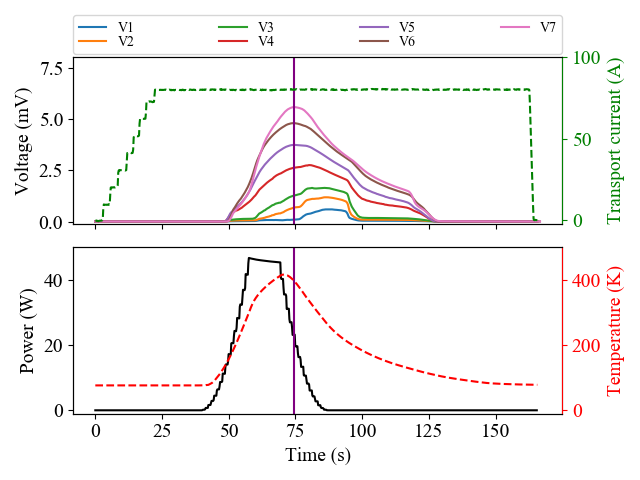

V_heater 8.5 : Max V7 = 0.0055683980000000004 V, index 372
[9.180000e-05 6.754760e-04 1.263813e-03 2.619989e-03 3.737450e-03
 4.795601e-03 5.581098e-03 4.185125e-03 3.271248e-03 2.417187e-03
 1.641234e-03 5.616940e-04]


<IPython.core.display.Javascript object>


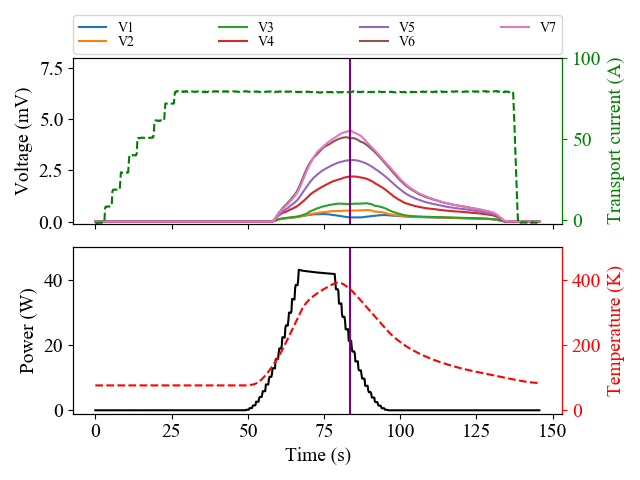

V_heater 8.5 : Max V7 = 0.00441792 V, index 418
[0.00020435 0.00053699 0.00085046 0.00219345 0.00299184 0.00406272
 0.00443102 0.00322873 0.00234029 0.00170212 0.0012904  0.00072563]


<IPython.core.display.Javascript object>


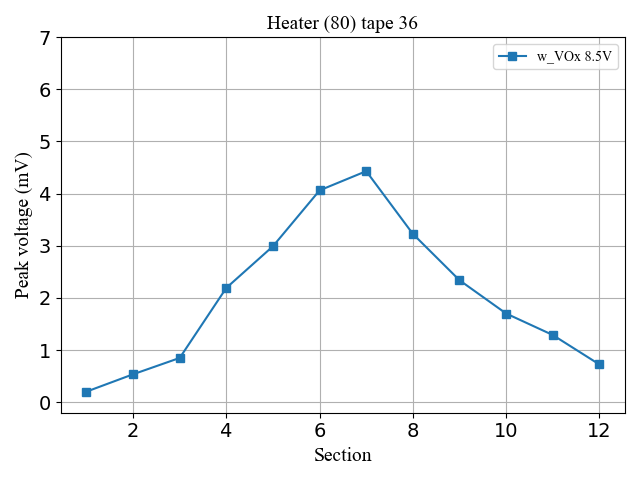

<IPython.core.display.Javascript object>


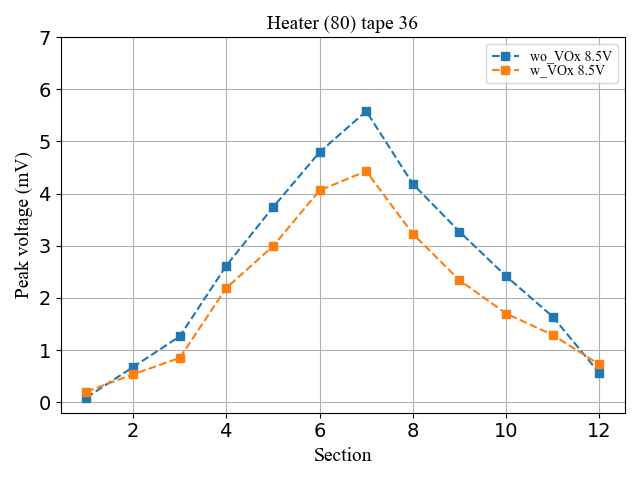

In [4]:
%matplotlib notebook 

# Choose different color for the voltage traces
#sns.set_palette(sns.color_palette("hls", 12))
#sns.set_palette(sns.cubehelix_palette(12))
#sns.set_palette(sns.cubehelix_palette(12, start=-.75, rot=.9))
#sns.set_palette(sns.hls_palette(15, l=.3, s=.8))
#sns.set_palette(sns.color_palette("magma", 7))
#sns.set_palette(sns.color_palette("tab20", 7))
#sns.set_palette(sns.color_palette("Paired", 12))

tape_number = 36
current_percent = 80 # transport current applied to the tape
coating = 'wo' # without coating
filename_wo = f'Tape {tape_number} heater {current_percent} A peak voltages without coating.txt'

Vheater = [8.5]
file_csv = [
#'tape36_w_cu_thin_2020-02-10-16-10-57.csv', #6
#'tape36_w_cu_thin_2020-02-10-17-21-44.csv', #7
#'tape36_w_cu_thin_2020-02-10-15-47-46.csv', #8
#'tape36_w_cu_thin_2020-02-10-16-00-54.csv', #8
#'tape36_w_cu_thin_2020-02-10-15-24-38.csv', #8.5
'tape36_w_cu_thin_2020-02-10-15-37-11.csv' #8.5
]


for i in range(len(file_csv)):
    filenumber = i
    main(file_csv[i],tape_number,Vheater[i],filenumber,current_percent,filename_wo,coating)
    
    
v_profile_plot(filename_wo)

#%matplotlib notebook
tape_number = 36
current_percent = 80
coating = 'w' # with coating
filename_w = f'Tape {tape_number} heater {current_percent} A peak voltages with coating.txt'

Vheater = [8.5]
file_csv = [
#'tape36_w_cu_coating_2020-02-12-13-36-18.csv', #6
#'tape36_w_cu_coating_2020-02-12-13-49-37.csv', #6
#'tape36_w_cu_coating_2020-02-12-14-01-48.csv', #7
#'tape36_w_cu_coating_2020-02-12-14-15-24.csv', #7
#'tape36_w_cu_coating_2020-02-12-14-30-05.csv', #8
#'tape36_w_cu_coating_2020-02-12-14-53-43.csv', #8
'tape36_w_cu_coating_2020-02-12-15-22-52.csv' #8.5
#'tape36_w_cu_coating_2020-02-12-15-46-46.csv' #8.5
]
 # 'tape36_w_cu_coating_2020-02-12-15-06-43.csv', 8.5 V (This file gives weird results)

for i in range(len(file_csv)):
    filenumber = i
    main(file_csv[i],tape_number,Vheater[i],filenumber,current_percent,filename_w,coating)
    
    
v_profile_plot(filename_w)
fig,ax = plt.subplots()
v_profile_plot2(filename_wo,'wo')
v_profile_plot2(filename_w,'w')
plt.grid()
plt.show()
plt.savefig('Tape36_8_5V.png')